# Using Support Vector Machine on the Malaria Dataset

In [44]:
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from collections import Counter
import cv2
from concurrent import futures
import threading
import datetime
import random

## Preprocessing the data

- create a list of pathnames of the dataset of infected and healthy cell images
- check number of image

In [45]:
infected_files = glob.glob('./cell_images/Parasitized/*.png')
healthy_files = glob.glob('./cell_images/Uninfected/*.png')
print("Number of infected and healthy cell images:",len(infected_files),len(healthy_files))

Number of infected and healthy cell images: 13779 13779


- create a dataframe using pandas

In [46]:
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': 13779*['Infected'] + 13779*['Healthy']
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head(5)

,filename,label
0,./cell_images/Parasitized/C180P141NThinF_IMG_2...,Infected
1,./cell_images/Parasitized/C84P45ThinF_IMG_2015...,Infected
2,./cell_images/Uninfected/C204ThinF_IMG_2015102...,Healthy
3,./cell_images/Uninfected/C76P37ThinF_IMG_20150...,Healthy
4,./cell_images/Uninfected/C141P102ThinF_IMG_201...,Healthy


- change the size of the image to one size (50,50) and grayscale it

In [47]:
def change_image_size_color_parallel(number, image):
    """
    resizes an image to the size (50,50) and grayscales it
    input: number - index of image, image - array with size (#pixel width, #pixel height, color channel RGB)
    output: image as numpy array with size (50,50,gray parameter)
    """
    if number%5000 == 0:
        print('Working on image number:', number)
    image = rgb2grey(cv2.resize(cv2.imread(image), dsize=(50,50), interpolation=cv2.INTER_AREA))
    return np.array(image, dtype=np.float32)

ex = futures.ThreadPoolExecutor(max_workers=None)
cell_files = files_df['filename'].values
cell_labels = files_df['label'].values
cell_files_number = [(number, image) for number, image in enumerate(cell_files)] 

# resizes train validation and test images
cell_data = np.array(list(ex.map(change_image_size_color_parallel, [data[0] for data in cell_files_number],
        [data[1] for data in cell_files_number])))

print("Shape of cell data after resizing and grayscaling:", cell_data.shape)

Working on image number: 0
Working on image number: 5000
Working on image number: 10000
Working on image number: 15000
Working on image number: 20000
Working on image number: 25000
Shape of cell data after resizing and grayscaling: (27558, 50, 50)


- plot the resized data

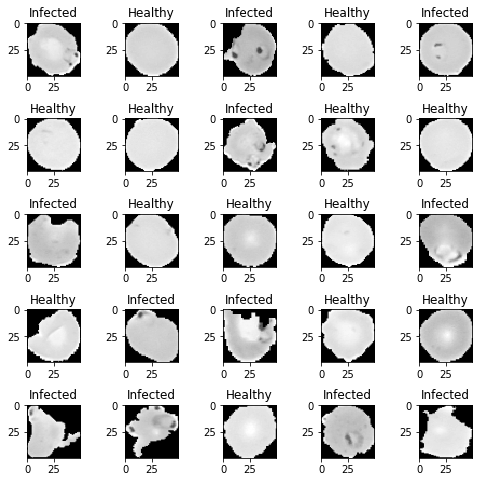

In [48]:
plt.figure(1 , figsize = (8 , 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(hspace = 0.8 , wspace = 0.8)
    random_number = random.choice(range(27558))
    plt.imshow(cell_data[random_number], cmap=mpl.cm.gray)
    plt.title(cell_labels[random_number])

- compute the normalized histogram of colours for the images

In [49]:
def histnorm_cell_images(data):
    """
    computes the normalized histogram of colors for the images
    input: array of the image data that is 3 dimensional
    output: array of normalized histogram of colours of the image data
    """
    number = 0
    histnorm_data = np.zeros((data.shape[0],10))
    for i, cell_image in enumerate(data):
        if number%5000 == 0:
            print('Working on image number:', number)
        counts, bins = np.histogram(cell_image, bins=10, range=(0.1,1))
            # starts from 0.1 to eliminate all black background
        histnorm_data[i] = counts / np.sum(counts)
        number += 1
    return histnorm_data.astype('float32')

cell_data = histnorm_cell_images(cell_data)

print("Shape of the normalized histogram of colors of cell data:", cell_data.shape)

Working on image number: 0
Working on image number: 5000
Working on image number: 10000
Working on image number: 15000
Working on image number: 20000
Working on image number: 25000
Shape of the normalized histogram of colors of cell data: (27558, 10)


- encode the labels to digits 0 and 1

In [50]:
le = LabelEncoder()
le.fit(cell_labels)

print(cell_labels[:6])
cell_labels = le.transform(cell_labels) 
print(cell_labels[:6])

['Infected' 'Infected' 'Healthy' 'Healthy' 'Healthy' 'Healthy']
[1 1 0 0 0 0]


## Hyperparameter Tuning 

- number of principal components

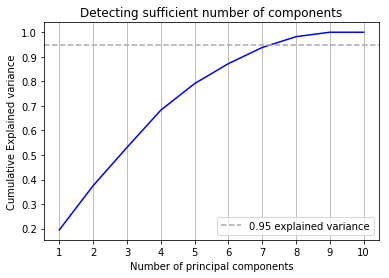

In [9]:
pca = PCA()
ss = StandardScaler()
ss.fit(cell_data)

pca.fit(ss.transform(cell_data))
Y = pca.explained_variance_ratio_.cumsum()
X = np.array(range(1, len(Y)+1))

plt.figure(figsize=(6, 4))
plt.plot(X, Y, color = 'blue')
plt.axhline(y = 0.95, color='darkgrey', linestyle='--', label = '0.95 explained variance')
plt.grid(True, axis='x')

plt.title('Detecting sufficient number of components')
plt.legend(loc='lower right')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Number of principal components')
plt.xticks(X)
plt.show()

We figured out that we can cover 95 % cumulative explained variance by using seven components. Through grid search we can find the best $\gamma$ and $C$ for training later.

- searching for best values for hyperparameters gamma and C

In [10]:
pipeline = Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=7)),('svc',SVC())])
parameter = {'svc__C': 10.**np.arange(-1, 3),'svc__gamma': 10.**np.arange(-1, 3)}

search = GridSearchCV(pipeline, parameter, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2)
search.fit(cell_data, cell_labels)

print("Parameters:",search.best_params_)
print("Highest mean accuracy:", search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] ....................... svc__C=0.1, svc__gamma=0.1, total=  38.6s
[CV] ....................... svc__C=0.1, svc__gamma=0.1, total=  38.4s
[CV] ....................... svc__C=0.1, svc__gamma=0.1, total=  38.6s
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] svc__C=0.1, svc__gamma=1.0 ......................................
[CV] svc__C=0.1, svc__gamma=1.0 ......................................
[CV] ....................... svc__C=0.1, svc__gamma=0.1, total=  38.6s
[CV] svc__C=0.1, svc__gamma=1.0 ......................................
[CV] ....................... svc__C=0.1, svc__gamma=1.0, total=  31.2s
[CV] ...........

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.4min


[CV] ...................... svc__C=1.0, svc__gamma=10.0, total= 1.9min
[CV] svc__C=1.0, svc__gamma=100.0 ....................................
[CV] ...................... svc__C=1.0, svc__gamma=10.0, total= 1.4min
[CV] svc__C=1.0, svc__gamma=100.0 ....................................
[CV] ..................... svc__C=1.0, svc__gamma=100.0, total= 2.2min
[CV] svc__C=1.0, svc__gamma=100.0 ....................................
[CV] ..................... svc__C=1.0, svc__gamma=100.0, total= 2.2min
[CV] svc__C=10.0, svc__gamma=0.1 .....................................
[CV] ..................... svc__C=1.0, svc__gamma=100.0, total= 2.2min
[CV] svc__C=10.0, svc__gamma=0.1 .....................................
[CV] ...................... svc__C=10.0, svc__gamma=0.1, total=  24.6s
[CV] svc__C=10.0, svc__gamma=0.1 .....................................
[CV] ...................... svc__C=10.0, svc__gamma=0.1, total=  24.5s
[CV] svc__C=10.0, svc__gamma=0.1 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 34.7min finished


Parameters: {'svc__C': 10.0, 'svc__gamma': 1.0}
Highest mean accuracy: 0.8225923506785688


## Train the SVM model 
- create the PCA matrix

In [51]:
# get shape of feature matrix
print('Feature matrix shape is: ', cell_data.shape)

# define standard scaler
ss = StandardScaler()
ss.fit(cell_data)
# run this on our feature matrix
cell_data_stand = ss.transform(cell_data)

pca = PCA(n_components=7)
ss.fit(cell_data_stand)
cell_pca = ss.transform(cell_data_stand)

# look at new shape
print('PCA matrix shape is: ', cell_pca.shape)

Feature matrix shape is:  (27558, 10)
PCA matrix shape is:  (27558, 10)


- split data in train and test dataset

In [52]:
X = pd.DataFrame(cell_pca)
X_train, X_test, y_train, y_test = train_test_split(X,cell_labels,test_size=.3,random_state=42)

# look at the distrubution of labels in the training dataset
pd.Series(y_train).value_counts()

0    9704
1    9586
dtype: int64

- start the training itself

In [53]:
# define support vector classifier
svm = SVC(kernel='rbf', gamma=1, C=10, probability=True)

# fit model
svm.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Results

- accuracy

In [54]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.8190614417029511


- confusion matrix

In [55]:
print(y_pred[:10])
confusion_matrix(y_test, y_pred)

[1 0 0 0 0 1 1 1 1 0]


array([[3479,  596],
       [ 900, 3293]])

- ROC curve and AUC

No handles with labels found to put in legend.


0.8958226316428636


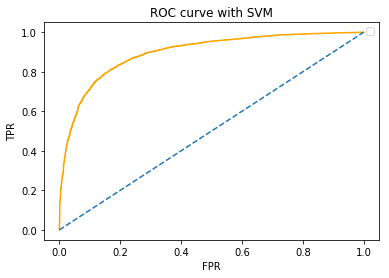

In [57]:
y_proba = (svm.predict_proba(X_test))[:, 1]

# get fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# plot ROC curve
plt.plot(fpr,tpr,color ='orange')
plt.plot([0,1], [0,1],ls='--')
plt.title('ROC curve with SVM')
plt.ylabel('TPR')
plt.xlabel('FPR');

# calculate AUC
print(auc(fpr, tpr))